| **Variable Name**        | **Type**     | **Description** | **Units** | **Comments**                                                                 |
|--------------------------|--------------|-----------------|-----------|-----------------------------------------------------------------------------|
| **Date**                  | Date         | Date in format dd/mm/yyyy | None      | Date and time of the power measurement.                                      |
| **Time**                  | Categorical  | Time in format hh:mm:ss | None      | Time of measurement, in 24-hour format.                                       |
| **Global_active_power**   | Continuous   | Household global minute-averaged active power | Kilowatt | Active power consumption of the household.                                  |
| **Global_reactive_power** | Continuous   | Household global minute-averaged reactive power | Kilowatt | Passive reactive power from resistance and capcitance on the grid                           |
| **Voltage**               | Continuous   | Minute-averaged voltage | Volt      | Voltage at the household measured in volts.                                 |
| **Global_intensity**      | Continuous   | Household global minute-averaged current intensity | Ampere    | Intensity of the current flowing through the household.                     |
| **Sub_metering_1**        | Continuous   | Energy sub-metering No. 1 (in watt-hour of active energy) | Watt-hour (active energy) | Power consumption for the kitchen appliances.                             |
| **Sub_metering_2**        | Continuous   | Energy sub-metering No. 2 (in watt-hour of active energy) | Watt-hour (active energy) | Power consumption for the laundry room appliances.                        |
| **Sub_metering_3**        | Continuous   | Energy sub-metering No. 3 (in watt-hour of active energy) | Watt-hour (active energy) | Power consumption for the water heater and air conditioning.               |


In [1]:
#Importing data and looking at the frist, and last few rows.
#Path was chnaged

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


path = 'household_power_consumption.txt' 
data = pd.read_csv(path, sep=';', low_memory=False)

print(data.columns)
print("Power Type", data['Global_active_power'].dtype) # Looking at data type, because it wasn't processing. Had to change to numeric

pd.set_option('display.width', None)  # To see more data across screen
pd.set_option('display.max_columns', None)  #Show all columns 

# Display some data
print(data.head())  # Display first 5 rows
print(data.tail())  # Display last 5 rows
print(data.shape)


Index(['Date', 'Time', 'Global_active_power', 'Global_reactive_power',
       'Voltage', 'Global_intensity', 'Sub_metering_1', 'Sub_metering_2',
       'Sub_metering_3'],
      dtype='object')
Power Type object
         Date      Time Global_active_power Global_reactive_power  Voltage  \
0  16/12/2006  17:24:00               4.216                 0.418  234.840   
1  16/12/2006  17:25:00               5.360                 0.436  233.630   
2  16/12/2006  17:26:00               5.374                 0.498  233.290   
3  16/12/2006  17:27:00               5.388                 0.502  233.740   
4  16/12/2006  17:28:00               3.666                 0.528  235.680   

  Global_intensity Sub_metering_1 Sub_metering_2  Sub_metering_3  
0           18.400          0.000          1.000            17.0  
1           23.000          0.000          1.000            16.0  
2           23.000          0.000          2.000            17.0  
3           23.000          0.000          1.000    

In [2]:
#Data preprocessing

# Convert necessary columns to numeric
columns_to_convert = ['Global_active_power', 'Global_reactive_power', 'Voltage', 
                      'Global_intensity', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3']

for col in columns_to_convert:
    data[col] = pd.to_numeric(data[col], errors='coerce')


# Convert sub-metering values from watt-hours to kWh and Global Power from kW to kWh to make consistent
# For the rest of this analysis, the data is now energy, not power
data['Sub_metering_1'] = data['Sub_metering_1'] / (1000)
data['Sub_metering_2'] = data['Sub_metering_2'] / (1000)
data['Sub_metering_3'] = data['Sub_metering_3'] / (1000)
data['Global_active_power'] = data['Global_active_power'] / 60


#Adds in Residual as energy use not captured in any sub metering
data['Residual'] = (data['Global_active_power'] - data['Sub_metering_1'] - data['Sub_metering_2'] - data['Sub_metering_3'])

# Interpolate missing values for numeric columns
data[columns_to_convert] = data[columns_to_convert].interpolate(method='linear')

#Making sure the date format is consistent.
data['Date'] = pd.to_datetime(data['Date'], dayfirst=True)

print(data.head())

        Date      Time  Global_active_power  Global_reactive_power  Voltage  \
0 2006-12-16  17:24:00             0.070267                  0.418   234.84   
1 2006-12-16  17:25:00             0.089333                  0.436   233.63   
2 2006-12-16  17:26:00             0.089567                  0.498   233.29   
3 2006-12-16  17:27:00             0.089800                  0.502   233.74   
4 2006-12-16  17:28:00             0.061100                  0.528   235.68   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  Residual  
0              18.4             0.0           0.001           0.017  0.052267  
1              23.0             0.0           0.001           0.016  0.072333  
2              23.0             0.0           0.002           0.017  0.070567  
3              23.0             0.0           0.001           0.017  0.071800  
4              15.8             0.0           0.001           0.017  0.043100  


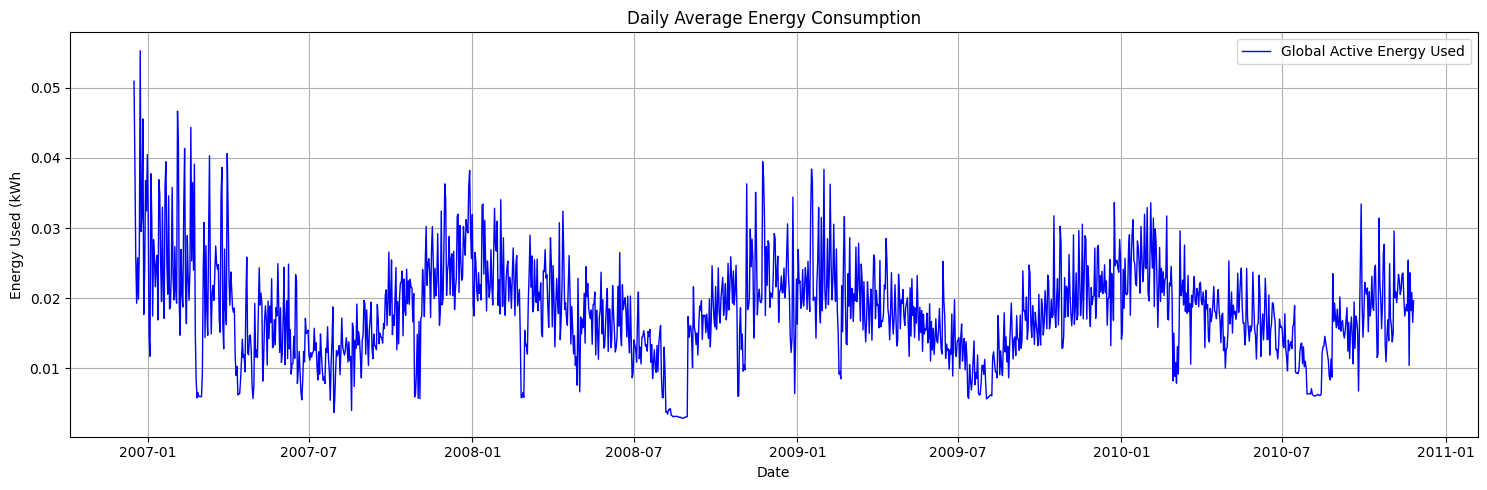

In [3]:
# Global energy by day

#Grouping the from minute-ly to daily
daily_energy = data.groupby('Date')[['Global_active_power', 'Residual']].mean() 

# Plotting a visualization of the global and residual power
plt.figure(figsize=(15, 5))
plt.plot(daily_energy.index, daily_energy['Global_active_power'], label='Global Active Energy Used', color='b', linewidth=1)
#plt.plot(daily_energy.index, daily_energy['Residual'], label='Residual Energy Use', color='purple', linestyle='--', linewidth=1)

# Plot parameters
plt.title('Daily Average Energy Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Used (kWh')
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

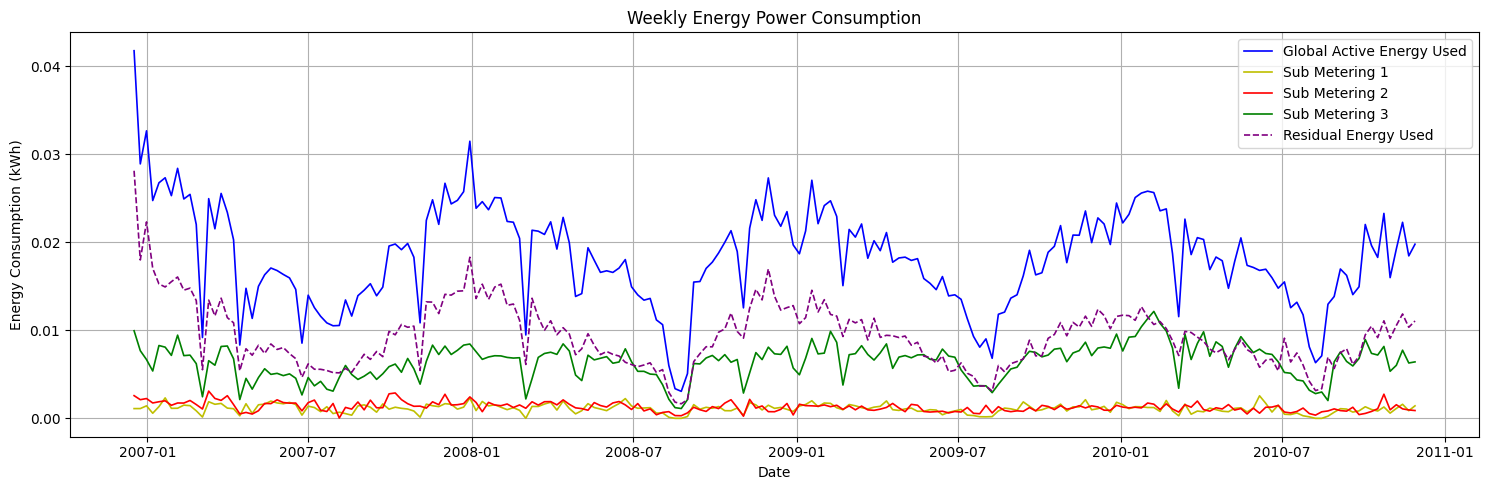

In [4]:
# Set the Date column as the index for resampling
if data.index.name != 'Date':
    data.set_index('Date', inplace=True)

# Resample by week and calculate the mean for each of the columns
weekly_data = data[['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Residual']].resample('W').mean()

# Plot the weekly data
plt.figure(figsize=(15, 5))

# Plot each line on the same graph
plt.plot(weekly_data.index, weekly_data['Global_active_power'], label='Global Active Energy Used', color='b', linewidth=1.2)
plt.plot(weekly_data.index, weekly_data['Sub_metering_1'], label='Sub Metering 1', color='y', linewidth=1.2)
plt.plot(weekly_data.index, weekly_data['Sub_metering_2'], label='Sub Metering 2', color='r', linewidth=1.2)
plt.plot(weekly_data.index, weekly_data['Sub_metering_3'], label='Sub Metering 3', color='g', linewidth=1.2)
plt.plot(weekly_data.index, weekly_data['Residual'], label='Residual Energy Used', color='purple', linestyle = '--', linewidth=1.2)

# Title and labels
plt.title('Weekly Energy Power Consumption')
plt.xlabel('Date')
plt.ylabel('Energy Consumption (kWh)')
plt.legend()
plt.grid(True)

# Tight layout for better formatting
plt.tight_layout()
plt.show()

In [5]:
#Calculate Mutual Information between Global Active and Sub-Metering

from sklearn.metrics import mutual_info_score

# Drop rows with NaN values in the relevant columns
data_N = data.dropna(subset=['Global_active_power', 'Sub_metering_1', 'Sub_metering_2', 'Sub_metering_3', 'Residual'])

def compute_mutual_info(col1, col2):
    bins1 = np.histogram_bin_edges(data_N[col1], bins='auto')
    bins2 = np.histogram_bin_edges(data_N[col2], bins='auto')
    binned1 = np.digitize(data_N[col1], bins=bins1)
    binned2 = np.digitize(data_N[col2], bins=bins2)
    mi = mutual_info_score(binned1, binned2)
    return mi

# Compute and print MI for each pair
mi_global_sub1 = compute_mutual_info('Global_active_power', 'Sub_metering_1')
mi_global_sub2 = compute_mutual_info('Global_active_power', 'Sub_metering_2')
mi_global_sub3 = compute_mutual_info('Global_active_power', 'Sub_metering_3')
mi_global_remain = compute_mutual_info('Global_active_power', 'Residual')

print(f"Mutual Information between Global_active_power and Sub_metering_1: {mi_global_sub1}")
print(f"Mutual Information between Global_active_power and Sub_metering_2: {mi_global_sub2}")
print(f"Mutual Information between Global_active_power and Sub_metering_3: {mi_global_sub3}")
print(f"Mutual Information between Global_active_power and Remaining Energy: {mi_global_remain}")

Mutual Information between Global_active_power and Sub_metering_1: 0.0807377194917662
Mutual Information between Global_active_power and Sub_metering_2: 0.10507114633070846
Mutual Information between Global_active_power and Sub_metering_3: 0.5116897182189863
Mutual Information between Global_active_power and Remaining Energy: 2.365679446241455


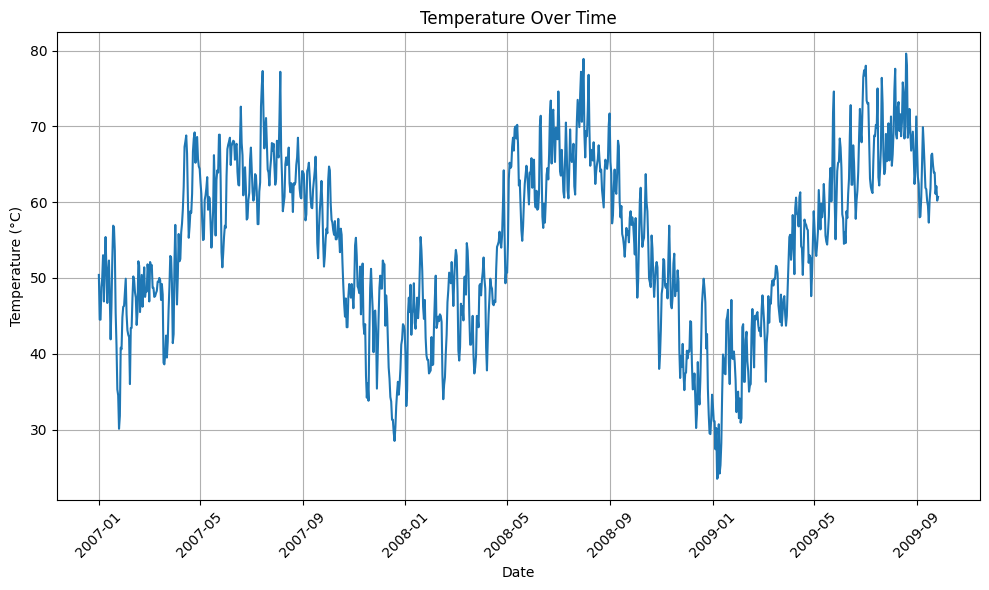

In [6]:
#Importing historic Paris weather data
#Source: https://www.visualcrossing.com/weather/weather-data-services#

weather = pd.read_csv('Paris_Weather.csv',parse_dates=['datetime'])

# Plot days vs temperature
plt.figure(figsize=(10, 6))
plt.plot(weather['datetime'], weather['temp'], label='Temperature', color='tab:blue')

# Title and labels
plt.title('Temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.tight_layout()
plt.show()


            Global_active_power  Sub_metering_3       temp
2007-01-07             0.024737        0.005376  48.300000
2007-01-14             0.026752        0.008271  50.771429
2007-01-21             0.027324        0.008087  50.471429
2007-01-28             0.025292        0.007151  36.314286
2007-02-04             0.028393        0.009449  46.214286


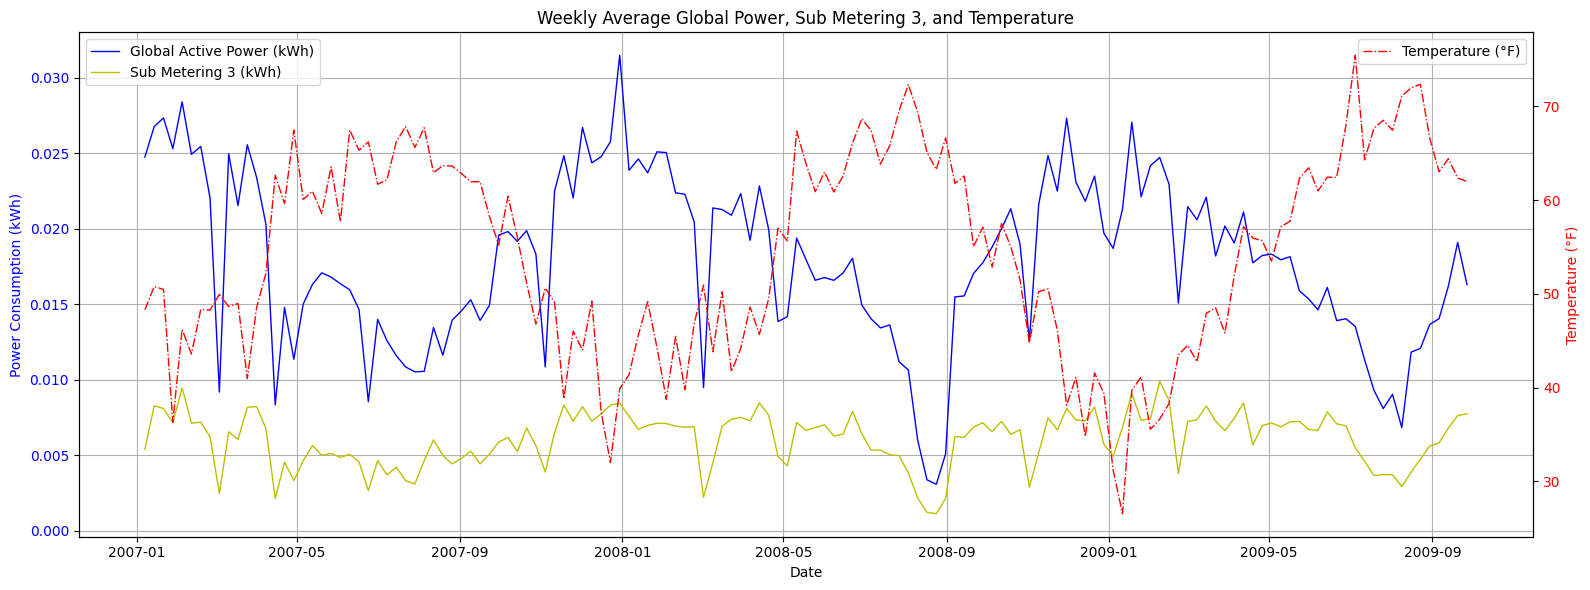

In [7]:
#Plotting the weather data and the energy data all on a single graph
#For better visualization purposes, weather and energy is grouped weekly, with average weekly values used

# Group 'data' by date and calculate the mean of the energy
data_grouped = data.groupby('Date')[['Global_active_power', 'Sub_metering_3']].mean()

# Group 'weather' by date and get the mean of the temperature
weather_grouped = weather.groupby('datetime')['temp'].mean()

# Merge the grouped data on the date
combined_data = pd.merge(data_grouped, weather_grouped, left_index=True, right_index=True, how='inner')

# Ensure the index is in datetime format
combined_data.index = pd.to_datetime(combined_data.index)

# Resample by week and take the mean
weekly_data = combined_data.resample('W').mean()

# View the resampled data
print(weekly_data.head())


# Create a figure and axis
fig, ax1 = plt.subplots(figsize=(16, 6))

# Plot Global Active Power on the left Y-axis
ax1.plot(weekly_data.index, weekly_data['Global_active_power'], label='Global Active Power (kWh)', color='b', linewidth=1)
ax1.plot(weekly_data.index, weekly_data['Sub_metering_3'], label='Sub Metering 3 (kWh)', color='y', linewidth=1)

# Set labels for the left Y-axis
ax1.set_xlabel('Date')
ax1.set_ylabel('Power Consumption (kWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')
ax1.grid(True)

# Create a second Y-axis for the temperature
ax2 = ax1.twinx()
ax2.plot(weekly_data.index, weekly_data['temp'], label='Temperature (°F)', color='r', linestyle='-.', linewidth=1)

# Set labels for the right Y-axis
ax2.set_ylabel('Temperature (°F)', color='r')
ax2.tick_params(axis='y', labelcolor='r')

# Title and formatting
plt.title('Weekly Average Global Power, Sub Metering 3, and Temperature')

# Add a legend for both Y-axes
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

# Tight layout for better formatting
plt.tight_layout()




In [8]:
# Calculate the correlation between Sub_metering_3 and Temperature
corr_sub_3 = combined_data['Sub_metering_3'].corr(combined_data['temp'])
corr_week_sub_3 = weekly_data['Sub_metering_3'].corr(combined_data['temp'])

# Calculate the correlation between Global_active_power and Temperature
corr_global = combined_data['Global_active_power'].corr(combined_data['temp'])
corr_week_global = weekly_data['Global_active_power'].corr(combined_data['temp'])

print(f'Correlation between Sub_metering_3 and Temperature: Daily: {corr_sub_3:.4f}, Weekly: {corr_week_sub_3:.4f}')
print(f'Correlation between Global_active_power and Temperature: Daily: {corr_global:.4f}, Weekly: {corr_week_global:.4f}')


Correlation between Sub_metering_3 and Temperature: Daily: -0.3605, Weekly: -0.5070
Correlation between Global_active_power and Temperature: Daily: -0.5622, Weekly: -0.7252



Accuracy: 0.49000
F1 Score (Weighted): 0.48219


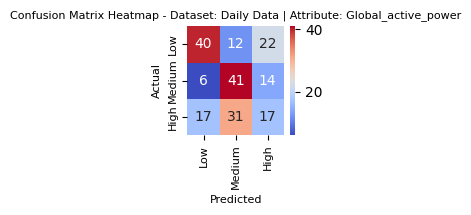


Accuracy: 0.75862
F1 Score (Weighted): 0.75141


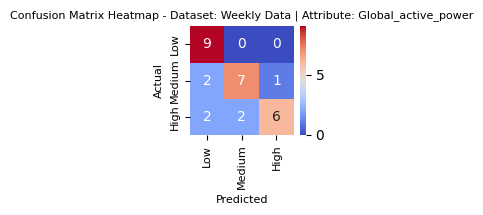


Accuracy: 0.42000
F1 Score (Weighted): 0.42063


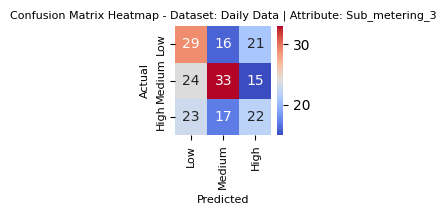


Accuracy: 0.51724
F1 Score (Weighted): 0.44921


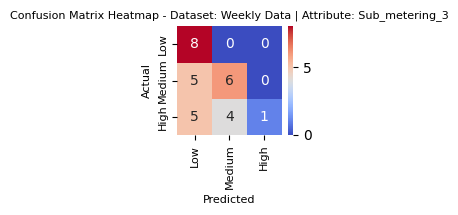

In [9]:
#Classfication functions to apply different classifier models for prediction
#Uses Temperature as data and energy as label
#Model attempts to classify temperature to low, medium, high energy usage


from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import seaborn as sns

def energy_use(dataset, set_name, attribute_name):
    # Calculate quantiles for categorization
    quantiles = dataset[attribute_name].quantile([.33, .67])

    # Categorize energy use into  Low, Medium, High
    def categorize(energy):
        if energy <= quantiles[0.33]:
            return 'Low'
        elif energy <= quantiles[0.67]:
            return 'Medium'    
        else:
            return 'High'

    # Set'Energy Use Level'
    dataset['Energy Use Level'] = dataset[attribute_name].apply(categorize)

    # Set X and Y (temperature) and the target (Energy Use)
    X = dataset[['temp']]  # Feature: Temperature
    y = dataset['Energy Use Level']  # Target: Enery Use (Low, Medium, High)

    # Train-test split 80/20
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 0)

    # Initialize classifier. Uncomment the one to use
    #classifier = LogisticRegression(max_iter=1000)
    #classifier = RandomForestClassifier(n_estimators=100, random_state=0)
    classifier = KNeighborsClassifier(n_neighbors=4)
    # Fit the model to the training data
    classifier.fit(X_train, y_train)

    # Predict on the test data
    y_pred = classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Output the results
    #print(f'\nResults for Dataset: {set_name} | Attribute: {attribute_name}')
    print(f'\nAccuracy: {accuracy:.5f}')
    print(f'F1 Score (Weighted): {f1:.5f}') 
    #print(f'Confusion Matrix:\n{conf_matrix}')

    # Plot the heatmap
    plt.figure(figsize=(2,2.25))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Low', 'Medium', 'High'], yticklabels=['Low', 'Medium', 'High'])
    plt.title(f'Confusion Matrix Heatmap - Dataset: {set_name} | Attribute: {attribute_name}', fontsize =8 )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8) 
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8) 
    plt.tight_layout() 
    plt.tight_layout()
    plt.show()

#Call the classifier function. Varies between Daily and Weekly Data and Global Energy and Sub 3 Energy
energy_use(combined_data,'Daily Data', 'Global_active_power')
energy_use(weekly_data, 'Weekly Data', 'Global_active_power')
energy_use(combined_data, 'Daily Data', 'Sub_metering_3')
energy_use(weekly_data, 'Weekly Data', 'Sub_metering_3')



Accuracy: 0.49000
F1 Score (Weighted): 0.47565


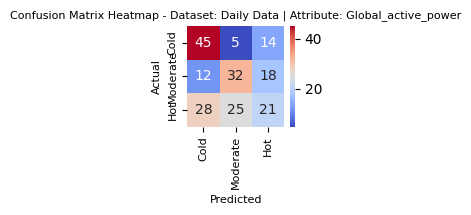


Accuracy: 0.58621
F1 Score (Weighted): 0.53489


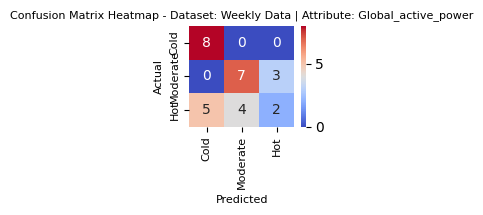


Accuracy: 0.42000
F1 Score (Weighted): 0.38929


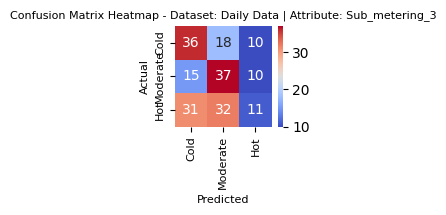


Accuracy: 0.48276
F1 Score (Weighted): 0.42837


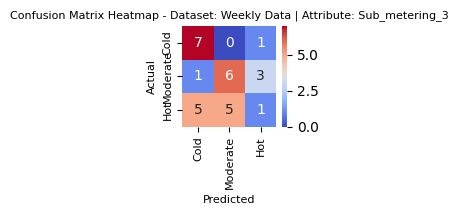

In [10]:
#Classfication functions to apply different classifier models for prediction
#Uses Temperature as data and energy as label
#Model attempts to classify energy usage to Cold, Moderate, Hot temperatures

def temp_predict(dataset, set_name, attribute_name):
    # Categorize temperature into Cold, Moderate, Hot
    temp_quantiles = dataset['temp'].quantile([0.33, 0.67])

    def categorize_temperature(temp):
        if temp <= temp_quantiles[0.33]:
            return 'Cold'
        elif temp <= temp_quantiles[0.67]:
            return 'Moderate'
        else:
            return 'Hot'

    dataset['Temperature Category'] = dataset['temp'].apply(categorize_temperature)

    # Set X and Y (energy attribute) and the target (Temperature Category)
    X = dataset[[attribute_name]]  # Energy attribute (Global or Sub 3 to model off of
    y = dataset['Temperature Category']  #Temperature Category (Cold, Moderate, Hot)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

    # Initialize classifier. Uncomment the one to use
    #classifier = LogisticRegression(max_iter=1000)
    #classifier = RandomForestClassifier(n_estimators=100, random_state=0)
    classifier = KNeighborsClassifier(n_neighbors=4)
    # Fit the model to the training data
    classifier.fit(X_train, y_train)

    # Predict on the test data
    y_pred = classifier.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    conf_matrix = confusion_matrix(y_test, y_pred)

    # Output the results
    #print(f'\nResults for Dataset: {set_name} | Attribute: {attribute_name}')
    print(f'\nAccuracy: {accuracy:.5f}')
    print(f'F1 Score (Weighted): {f1:.5f}') 
    #print(f'Confusion Matrix:\n{conf_matrix}')

    # Plot the heatmap
    plt.figure(figsize=(2,2.25))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='coolwarm', xticklabels=['Cold', 'Moderate', 'Hot'], yticklabels=['Cold', 'Moderate', 'Hot'])
    plt.title(f'Confusion Matrix Heatmap - Dataset: {set_name} | Attribute: {attribute_name}', fontsize =8 )
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.xlabel('Predicted', fontsize=8)
    plt.ylabel('Actual', fontsize=8) 
    plt.xticks(fontsize=8)  
    plt.yticks(fontsize=8) 
    plt.tight_layout() 
    plt.tight_layout()
    plt.show()

# Call the function with your datasets
temp_predict(combined_data, 'Daily Data', 'Global_active_power')
temp_predict(weekly_data, 'Weekly Data', 'Global_active_power')
temp_predict(combined_data, 'Daily Data', 'Sub_metering_3')
temp_predict(weekly_data, 'Weekly Data', 'Sub_metering_3')
